In [1]:
# -*- coding: utf-8 -*-
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from lxml import objectify
from pandas import DataFrame
from datetime import datetime, date, time
from dateutil.parser import parse
import pandas as pd
import numpy as np
import sklearn as sk
import time
import sys
from sklearn import metrics
import re
from numpy.random import seed
import nltk.stem
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)
ru_stemmer = nltk.stem.SnowballStemmer('russian')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([ru_stemmer.stem(w) for w in analyzer(doc)])



In [2]:
data_start=pd.read_pickle('data/WikiData_dat_5.pkl')

print (len(data_start), data_start.head())
topic=[]
for row in data_start['cat'].tolist():
    if "спорт" in row:
        topic.append("sport")
    else:
        topic.append("other")
print (len(topic))
data_start['topic']=topic


10748         id                                              title  \
1349  1349  россия удивлена заявлениями премьер-министра у...   
1353  1353   впервые зарегистрирован свет самых древних звезд   
1359  1359                            день народного единства   
1361  1361                                беспорядки в париже   
1381  1381                парламентские выборы в азербайджане   

                  autor                                               text  \
1349         Krassotkin  {{:дата|3 ноября 2005}} {{украина}}в [[w:ru:мо...   
1353         Krassotkin  {{дата|3 ноября 2005}}{{астрономия}}[[:w:спитц...   
1359         Krassotkin  {{дата|4 ноября 2005}}в россии первый раз праз...   
1361         Krassotkin  {{дата|5 ноября 2005}} {{франция}}[[изображени...   
1381  Artem Korzhimanov  {{дата|6 ноября 2005}}{{азербайджан}}6 ноября ...   

               data                                                cat  \
1349  3 ноября 2005  россия, украина, политика, вто, юрий ех

In [3]:
data_bi=data_start[['title', 'cat', 'text2', 'noun', 'topic']][:3000]
data_test=data_start[['title', 'cat', 'text2', 'noun', 'topic']][3000:4000]
d_sport = (data_bi['topic']==u'sport')
data=data_bi.loc[d_sport]
print (len(data), len(data_test))
dfTimeUniqCat=pd.unique(data.topic.ravel())
print (len(dfTimeUniqCat))
category = data['topic'].tolist()
category = [str(i) for i in category]
#category = list(map(str, category))
content = data['title'].tolist()
stop_words = ['и']
content  = [str(x) for x in content]
for x in category:
    if not isinstance(x, str):
        print (x)


117 1000
1


In [4]:
%%time
vectorizerContent = StemmedCountVectorizer (min_df=1, stop_words=stop_words, lowercase=True, analyzer="word")
vectorizerContent_2 = CountVectorizer (min_df=1, lowercase=True, analyzer="word", binary=True, ngram_range=(1, 1))
vectorizerCategory = CountVectorizer (min_df=1)

X = vectorizerContent.fit_transform(content)
X_2=vectorizerContent_2.fit_transform(content)
Xcat = vectorizerCategory.fit_transform(category)
xx = X.toarray().transpose()
xxcat = Xcat.toarray().transpose()

selected_feature_names_Cont = np.asarray(vectorizerContent.get_feature_names())
selected_feature_names_Cat = np.asarray(vectorizerCategory.get_feature_names())


Wall time: 62 ms


In [6]:
class OcTm (object):
    def __init__(self,  eta=1.0):
        self.eta=eta
        
    def fit(self, X, y):
        wordTopic=X.toarray().transpose() @ y
        self.ProbTopicWord = wordTopic.transpose()/np.sum(wordTopic, axis=1)
        ProbTopicDoc=X@self.ProbTopicWord.transpose()
        self.ProbTopicDoc=ProbTopicDoc.transpose()/np.sum(ProbTopicDoc, axis=1)
        return self
    
    def predict(self, query):
        predictMatrixW = []
        el_data= {}
        new_text_1=re.findall('\w+', query)
        new_text_2 = vectorizerContent_2.transform(new_text_1).toarray()
        penalty=(len(new_text_1)-sum(sum(new_text_2)))*self.eta
        self.new_text_1=new_text_1
        self.new_text_2=new_text_2
        self.penalty=penalty
        self.topicNew=np.dot(self.ProbTopicWord, vectorizerContent.transform([query]).toarray().transpose())
        el_data[selected_feature_names_Cat[0]] = self.topicNew.sum()
        el_data['other'] = penalty
        self.el_data=el_data
        predictMatrixW.append(dict(el_data))
        dfMW = DataFrame(predictMatrixW)
        dfSumMW=dfMW.sum()
        i =0
        dfSumMW.sort_values(ascending=False, kind='quicksort', na_position='last', inplace=True)
        for el in dfSumMW.T.iteritems():
            i += 1
            if i < 3:
                return (el[0], round(el[1]/dfSumMW.sum(), 2))



In [7]:
ot=OcTm(eta=1.0)
ot.fit(X, Xcat)

In [8]:
ot.predict ('рейтинг футбольных сборных')

('sport', 1.0)

In [9]:
%%time

i = 0
outputpredict = []
outputpredictVal=[]
executionTime=[]
for query in data_test['title']:
    start_time = time.time()
    out=ot.predict(query)
    end_time = time.time()
    execution_time = round(end_time - start_time, 5)
    outputpredict.append(out[0])
    outputpredictVal.append(out[1])
    i+=1
    executionTime.append(execution_time)
    if i%500==0:
        print (i, query, out[0], out[1], execution_time)

    

500 google обогнала microsoft и заняла второе место среди it-компаний по капитализации other 0.75 0.002
1000 санта-клаус прибыл в голливуд (видео) other 1.0 0.002
Wall time: 1.71 s


In [10]:
clean_test_reviews = []
for query in data_test['title']:
    clean_test_reviews.append(query)

In [11]:
output = pd.DataFrame( data={"title": clean_test_reviews, 'topic': outputpredict, 'val': outputpredictVal, 'time': executionTime} )
outClass=[]
try:
    outClass.append(output['topic'].value_counts()['other'])
except:
    outClass.append(0)
#print (output['topic'].value_counts()['other'])

In [12]:
output['topic'].value_counts()

other    943
sport     57
Name: topic, dtype: int64

accuracy:   0.936
[[924  45]
 [ 19  12]]


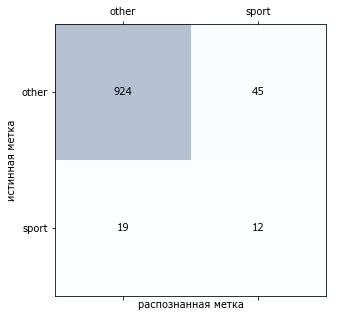

In [13]:
score = metrics.accuracy_score(data_test.topic.tolist(), outputpredict)
print("accuracy:   %0.3f" % score)

confmat=confusion_matrix(data_test.topic.tolist(), outputpredict)
print (confmat)
labels=['other', 'sport']
confmat=metrics.confusion_matrix(data_test.topic.tolist(), outputpredict, labels=labels)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    #print (labels[i])
    for j in range(confmat.shape[1]):
        #print (labels[j])
        ax.text(x=j, y=i,
               s=confmat[i,j],
               va='center', ha='center')
plt.xticks(np.arange(0,2), labels)
plt.yticks(np.arange(0,2), labels)
plt.xlabel('распознанная метка')
plt.ylabel('истинная метка')
plt.savefig('data/OC-TM_t-f.png')
plt.show()